## **_micrograduate_**: from backprop to GPT!

### 1. **micrograd**: implementing an autograd engine

We'll begin by implementing **micrograd**: an autograd engine. "autograd" stands for automatic backpropagation (**backprop**), where **backprop** refers to an algorithm that allows you to efficiently evaluate the gradient of an error or **loss** function with respect to (**w.r.t.**) the weights and biases of a neural network (**nn**). This allows us to iteratively tune these parameters, minimize the **loss** and therefore improve the accuracy of the network. **backprop** is at the mathematical core of any modern deep neural network library, like pytorch or jax. **micrograd**'s functionality is best illustrated by an example.

In [1]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}, the outcome of this forward pass')
g.backward()
print(f'{a.grad:.4f}, i.e. the numerical value of dg/da')
print(f'{b.grad:.4f}, i.e. the numerical value of dg/db')

24.7041, the outcome of this forward pass
138.8338, i.e. the numerical value of dg/da
645.5773, i.e. the numerical value of dg/db


You'll see that **micrograd** allows us to build out mathematical expressions. Here, we have an expression that we're building out where you have two inputs `a` and `b` whose values have been wrapped into a `Value` object that we are going to build out as part of **micrograd**. In this example, we build a mathematical expression graph. `a` and `b` are transformed into `c` and `d`, and eventually into `e`, `f` and `g` through some intermediary operations such as addition (`+`), multiplication (`*`), exponentiation to a constant power (e.g. `b**3`). Other operations include
offsetting by one, negation, squashing at zero, squaring, division, etc. And so from these values micrograd will, in the background, build out a mathematical expression graph. It will know, for example, that `c` is also a value but also a result of the addition operation of two child value nodes `a` and `b`, to which it will maintain pointers. So, we'll basically know exactly how all this operations graph is laid out. Then, we can do a forward pass (`a`, `b` -> ... -> `g`), but  also initiate the backward pass that constitutes **backprop** by calling `backward` at node `g`, `g.backward()`. What backpropagation is going to do is start at `g` and it's going to go backwards through that expression graph and it's going to recursively apply the chain rule from calculus. This allows it to evaluate the derivative of `g` with respect to all the internal nodes, like `e`, `d` and `c`, but also with respect to the inputs `a` and `b`. Then we can actually query this derivative of `g` with respect to, for example, a (`a.grad`) or the derivative of `g` with respect to `b` (`b.grad`). The values of these `grad` attributes tell us how `a` and `b` are affecting `g` through this mathematical expression. If we slightly nudge `a` and make it slightly larger, `a.grad == 138.8338` is telling us that `g` will grow and that the slope of that growth is going to be equal to that number. Similarly, the slope of growth of `g` with respect to a slight positive nudge of `b` is going to be `645.5773`. a **nn** is a function that takes in inputs and weights and returns an output: `F(in, w) = out`. **micrograd** will help you understand **nn**s at such a fundamental level by disregarding non-essential elements (e.g. tensors) that you would otherwise encounter in practice, production, etc. **micrograd** is all you need in order to understand the basics. Everything else is just efficiency. Now, let's dive right in and start implementing!

First, we must make sure that we develop a very good, intuitive understanding of what a derivative is and exactly what information it gives us.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib ipympl

In [3]:
def y(x):
    return 3*x**2 - 4*x + 5

In [4]:
y(3.0)

20.0

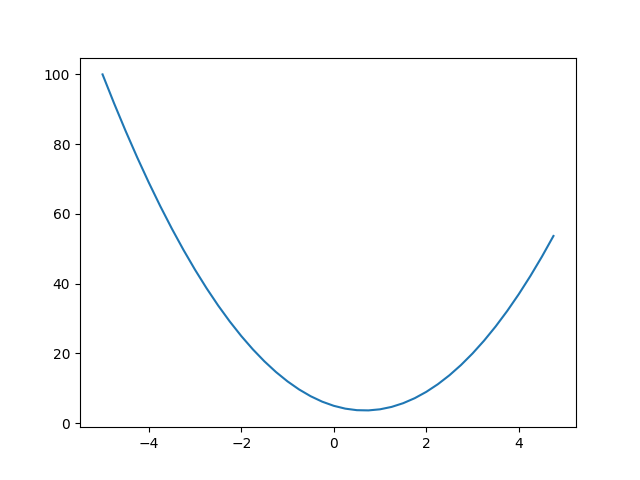

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = y(xs)
plt.figure();plt.plot(xs, ys);

Above, we plotted a parabola. Now, to think through what is the derivative of this function at any point x is, let's from the equivalent definition of [what it means for a function to be differentiable](https://en.wikipedia.org/wiki/Derivative#Definition). Understanding the derivative boils down to finding how a such a function `f` responds to a slight nudge of a small number `h` of its input `x`. Meaning, with what sensitivity does it respond? Does the value go up or down? Or, to be more precise, what is the slope at that point `x`? Is it positive or negative? This exact amount we are looking for is given to us by the limit equation that we can very simply approximate numerically with a small enough `h` value, as follows.

In [6]:
h = 0.00000001
x = 3.0  # try -3.0, 2/3, etc.
(y(x + h) - y(x))/h

14.00000009255109

Now, with a more complex example, to start building an intuition about the derivative, let's find out the derivatives of `d` w.r.t. `a`, `b` and `c`.

In [7]:
h = 0.00000000000001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h  # try nudging `b` or `c` instead to see what happens
d2 = a*b + c
print(f'd1: {d1}')
print(f'd2: {d2}')
print(f'slope: {(d2 - d1)/h}')

d1: 4.0
d2: 3.99999999999997
slope: -3.019806626980426


We now have some intuitive sense of what a derivative is telling us about a function. Now, let's move unto **nn** that are much more massive mathematical expressions. To do so easily, we must build some infrastructure.

In [8]:
class Value:
    def __init__(self, data, prev=(), op='', label='',):
        self.data = data
        self.prev = set(prev)
        self.op = op
        self.label = label
        self.grad = 0.
    def __repr__(self):
        return f"{self.__class__.__name__}(data='{self.data}'" + (f", label='{self.label}')" if self.label else ')')
    def __add__(self, other):
        return self.__class__(
            data=(self.data + other.data),
            prev=(self, other),
            op='+',
        )
    def __radd__(self, other):  # other + self
        return self + other
    def __mul__(self, other):
        return self.__class__(
            data=(self.data * other.data),
            prev=(self, other),
            op='*',
        )
    def __rmul__(self, other):  # other * self
        return self * other
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    def tanh(self):
        return self.__class__(
            data=math.tanh(self.data),
            prev=(self,),
            op='tanh',
        )
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
def forward_pass(label=False):
    d = a*b
    e = d + c
    L = e*f
    if label:
        d.label = 'd'
        e.label = 'e'
        L.label = 'L'
    return L
L = forward_pass(label=True)
L

Value(data='-8.0', label='L')

In [9]:
L.prev

{Value(data='-2.0', label='f'), Value(data='4.0', label='e')}

In [10]:
L.op

'*'

A `Value` object acts as a value holder and it can also perform operations (`+`, etc.) with other objects to produce new instances. Each such instance holds:
- some value `data`
- the operation `op` that produced it (e.g. `+`)
- its children `prev` a tuple of the `Value` instances that produced it
- its gradient `grad` that represents the derivative of some value (e.g. `L`)  w.r.t. it
- its backward

To recap what we have done so far: we have built scalar-valued mathematical expression graphs using operations such as addition and multiplication. To see such a graph that each `Value` object represents, let's define a visualization function `draw()` and call it on a `Value` object, e.g. `L`.

In [11]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (
            n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n.op, label=n.op)
            # and connect this node to it
            dot.edge(uid + n.op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    return dot


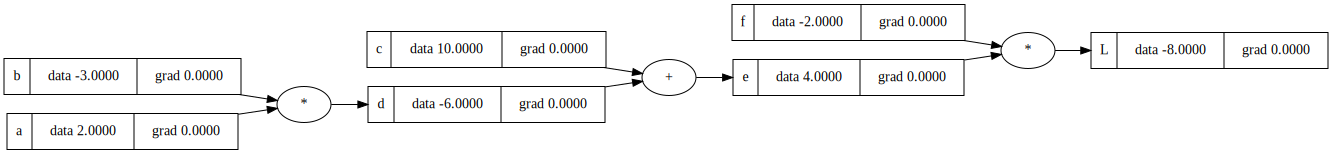

In [12]:
draw(L)

The above graph represents a forward pass. As a reminder, each `grad` attribute refers to how much each nudge of the value of a node (e.g. `c`) contributes to the output value `L`. Let's now, fill in those gradients by doing **backprop** manually. Starting at `L` (the end of the graph), we ask what is the derivative of `L` w.r.t. itself? Since `f(L) = L`, it is `(f(L + h) - f(L))/h = (L + h - L)/h`, ...

In [13]:
h = 0.001
L.grad = ((L.data + h) - L.data)/h
L.grad

1.000000000000334

...which equals `1`! Now, moving backwards in the graph, what about the derivative of `L` w.r.t. `e`, for example? Let's do the same and find out. This time `L(e) = e*f`. And so, `dL/de = (L(e + h) - L(e))/h = ((e + h)*f - e*f)/h = (e*f + h*f - e*f)/h = f`. Similarly, `dL/df = e`. Therefore:

In [14]:
e.grad = f.data
f.grad = e.data
print(e.grad)
print(f.grad)

-2.0
-7.0


Now, we will find `dL/dc`, which basically constitutes the crux of **backprop** and the most important node to understand. So, pay attention!
How do we find the derivative of `L` w.r.t. `c`? Very intuitively, by knowing `L` is sensitive to `d` (`dL/de`) and how `d` is sensitive to `c` (`de/dc`), we should be able to somehow put this information together and get our result. We know the former. Whereas, for the latter: `e(c) = c + d` and so `de/dc = (e(c + h) - e(c))/h = ((c + h + d) - (c + d))/h = 1` and similarly, `de/dd = 1`. That "somehow" is the [chain rule](https://en.wikipedia.org/wiki/Chain_rule), according to which: `dL/dc = (dL/de) * (de/dc)`. For us, this means:

In [15]:
c.grad = e.grad * 1.0
c.grad

-2.0

To sum up:
- we want `dL/dc`
- we know `dL/de`
- we know `de/dc`
- we apply the chain rule: `dL/dc = (dL/de) * (de/dc) = (dL/de) * 1 = dL/de`
- similarly: `dL/dd = (dL/de) * (de/dd) = (dL/de) * 1 = dL/de`

Easy! Notice the fact that `de/dc = de/dd = 1`. This equality verifies the fact that the addition operator (`+`) just acts as a router, merely distributing the derivative of the result (e.g. `dL/de`) backwards, through all the children nodes (e.g. `c` and `d`), without unperturbed.

To complete this session of manual **backprop**, we are going to recurse this process and re-apply the chain rule all the way back to the input nodes, `a` and `b`. Thus, we are looking for `dL/da` and `dL/db`, meaning:
- `dL/da = (dL/dd) * (dd/da)`
- `dL/db = (dL/dd) * (dd/db)`

We already know that:

In [16]:
f'dL/dd = dL/de = {e.grad}'

'dL/dd = dL/de = -2.0'

But, what about `dd/da` and `dd/db`? Let's derive them, the same way we did with `de/dc`:
- `dd/da = (d(a + h) - d(a))/h = (((a + h) * b) - (a * b))/h = (a*b + h*b - a*b)/h = h*b/h = b`
- `dd/db = a`

Therefore:

In [17]:
a.grad = e.grad * b.data
b.grad = e.grad * a.data
print(a.grad)
print(b.grad)

6.0
-4.0


If we re-draw our computational graph, we get:

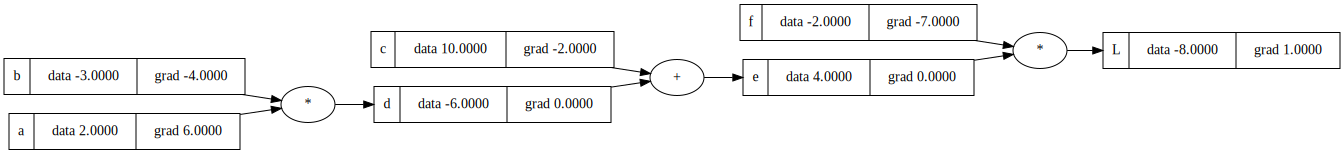

In [18]:
draw(L)

And that's what **backprop** is! Just the recursive application of the chain rule backwards through the computational graph for calculating the gradient of a **loss** value (`L`) w.r.t. all other values that produced it (`a`, `b`, etc.). The purpose being, to be able to use the gradient values to nudge the **loss** value: optimization step. This process goes as follows:
- to _increase_ `L`, let each value follow the gradient in the _positive_ direction
- to _decrease_ `L`, let each value follow the gradient in the _negative_ direction

Running the following example should increase the value of `L`:

In [19]:
Lold = L.data
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
d.data += 0.01 * d.grad
e.data += 0.01 * e.grad
f.data += 0.01 * f.grad
L = forward_pass()
print(f'old L: {Lold}')
print(f'new L: {L.data}')

old L: -8.0
new L: -7.695431999999999


You just learned how to apply one optimization step! Optimization is fundamental when it comes to training **nn**s, as you will see... So, eventually we want to build up a level of understanding for training such multilayer perceptrons (**mlp**s), as they are called.

#### MLP example

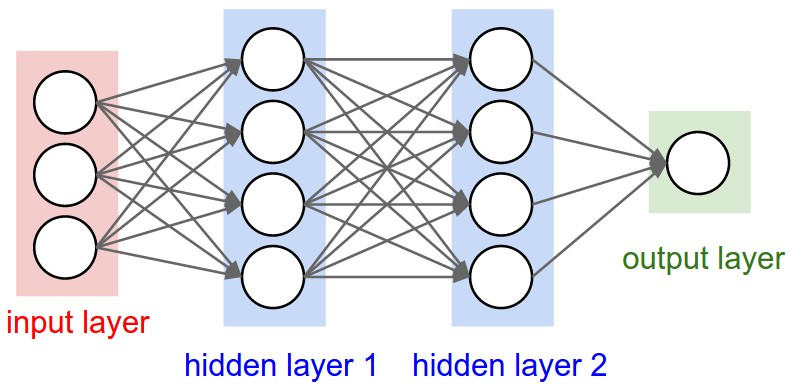

In [20]:
from IPython.display import Image, display
display(Image(filename='mlp.jpeg'))

 But first, let's explore an example for gaining the intuition for doing so: **backprop** through a simplified neuron.

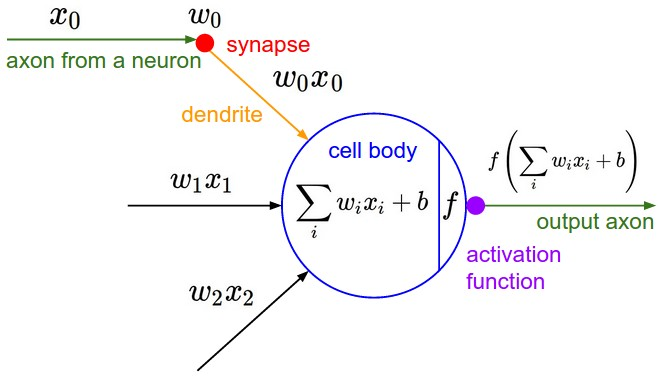

In [21]:
display(Image(filename='neuron.jpeg'))

Such a neuron:
- receives input $w_i x_i$ (output $x_i$ of incoming neuron multiplied by a synaptic weights $w_i$)
- summates those inputs $\displaystyle \sum_i w_i x_i$ at the cell body
- adds a bias $b$
- passes the result through an activation function $f$
- outputs the value $f\bigg(\displaystyle \sum_i w_i x_i + b\bigg)$

An activation function $f$ usually represents a squashing function such as $\tanh$:

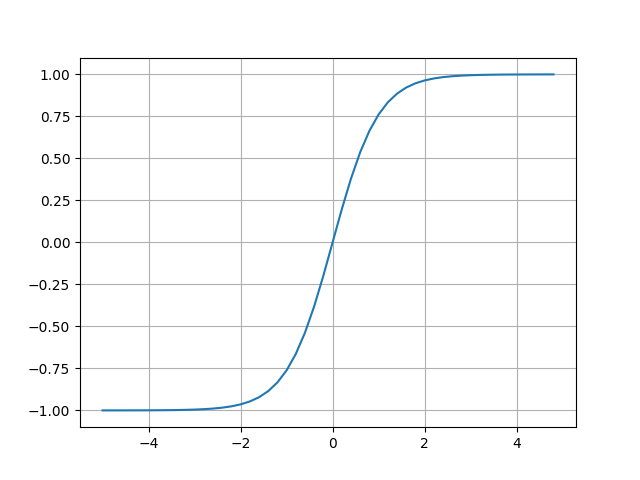

In [22]:
plt.figure();plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));plt.grid()

Let's extend our `Value` class to incorporate such a `tanh` activation function:

In [23]:
class Value(Value):
    def tanh(self):
        return self.__class__(
            data=math.tanh(self.data),
            prev=(self,),
            op='tanh',
        )

To simulate the functionality of this neuron:

In [24]:
def make_neuron_output():
    global x1, x2, w1, w2, b, x1w1, x2w2, sum_, n, o
    # inputs x1,x2
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    sum_ = x1w1 + x2w2; sum_.label = 'x1*w1 + x2*w2'
    n = sum_ + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'  # see the newly implemented Value.tanh method
make_neuron_output()

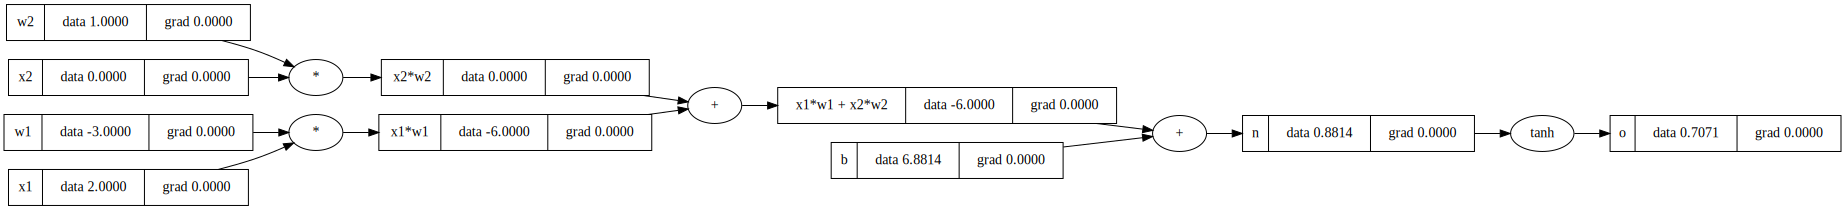

In [25]:
draw(o)

As you can see, this graph represents a neuron that takes inputs and weights and produces a value $n$ squashed by an activation function that outputs $o$. But, the grad attributes are empty. Let's fill them up by doing another manual **backprop**! Doing so requires finding out the derivatives of $o$ w.r.t. the inputs. But of course in a typical **nn** setting what we really care about the most are the derivatives w.r.t. the weights $w_i$ because those are the free parameters that are usually changed when improving performance.

In [26]:
o.grad = 1.0
o.grad

1.0

`do/dn = d(tanh(n))/dn = 1 - tanh(n)**2`, according to [hyperbolic functions derivatives](https://en.wikipedia.org/wiki/Hyperbolic_functions#Derivatives). Therefore:

In [27]:
n.grad = 1 - o.data**2
n.grad

0.4999999999999998

Since we know from before that the `+` operation acts as a gradient router and we can see from our graph that $n$ is recursively preceeded by two `+` operations, the children nodes's `grad` attribute will be the same value as: `n.grad`:

In [28]:
x2w2.grad = x1w1.grad = sum_.grad = b.grad = n.grad
x2w2.grad

0.4999999999999998

And according to the chain rule, as previously described, the derivatives of the inputs w.r.t to the outputs will be:
- `do/dx1 = (do/dx1w1) * (dx1w1/dx1) = (do/dx1w1) * w1`
- `do/dw1 = (do/dx1w1) * (dx1w1/dw1) = (do/dx1w1) * x1`
- `do/dx2 = (do/dx2w2) * (dx2w2/dx2) = (do/dx2w2) * w2`
- `do/dw2 = (do/dx2w2) * (dx2w2/dw2) = (do/dx2w2) * x2`
As such:

In [29]:
x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data
print(x1.grad)
print(w1.grad)
print(x2.grad)
print(w2.grad)

-1.4999999999999993
0.9999999999999996
0.4999999999999998
0.0


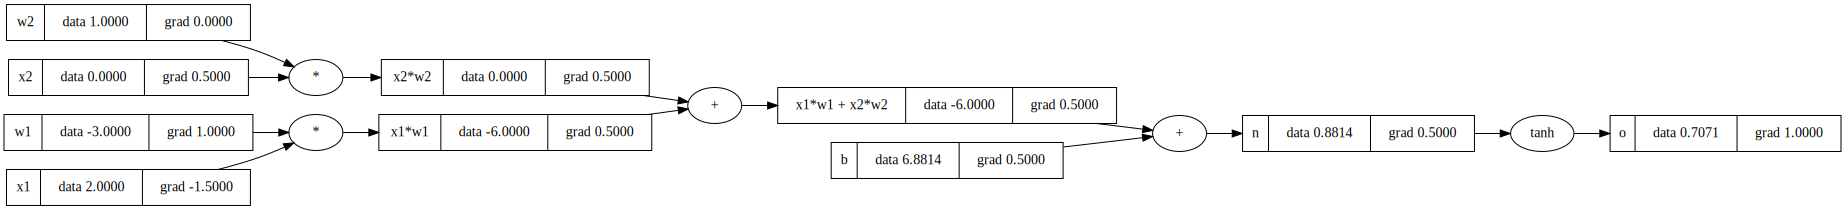

In [30]:
draw(o)

Done. Ok now, doing manual **backprop** is obviously ridiculous. So, we are gonna put an end to our suffering and see how we can do the backward pass automatically by codifying what we have learnt so far. Specifically, inside each operation of a `Value` instance, we will define a `backward` function that calculates each gradient.

In [31]:
class Value(Value):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._backward = lambda: None
    def __add__(self, other):
        other = other if isinstance(other, self.__class__) else self.__class__(other)        
        out = super().__add__(other)
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self, other):
        other = other if isinstance(other, self.__class__) else self.__class__(other)        
        out = super().__mul__(other)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        out = super().tanh()
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out

Notice: we accumulate each gradient (`+=`) instead of just assigning it (`=`). This guarantees that multiple backward calls on the same node are not overwritten the [multivariable case of the chain rule](https://en.wikipedia.org/wiki/Chain_rule#Multivariable_case). Now, with our enhanced class, let's re-make the neuron's output:

In [32]:
make_neuron_output()

and let's do automatic **backprop** with the help of the `backward` functions we just defined! Calling it on a value node will populate the `grad` attribute of the value nodes that produced it: essentially **backprop**.

In [33]:
o.grad = 1.0  # base case
o._backward()
n._backward()
b._backward()  # leaf node: nothing happens!
sum_._backward()
x2w2._backward()
x1w1._backward()
x2._backward()  # leaf node: nothing happens!
w2._backward()  # leaf node: nothing happens!
x1._backward()  # leaf node: nothing happens!
w1._backward()  # leaf node: nothing happens!

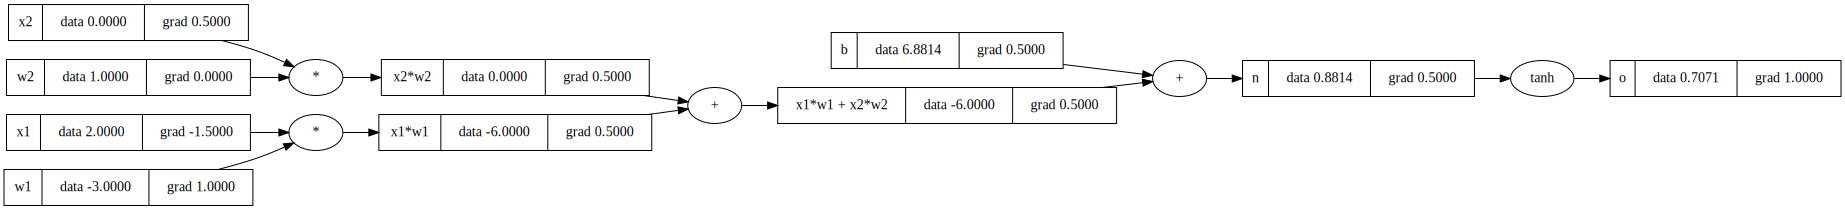

In [34]:
draw(o)

Hurray! We managed to ease the pain of manually calculating the gradients of each node. However, there's a problem: calling `backward` on a node (e.g. `x1w1`) will only work if `backward` has already been called on its descendant node(s) (e.g. `n`). In our graph topology this means that `backward` must be called from rightmost to leftmost nodes. This can be done easily by laying out our graph using [topological sorting](https://en.wikipedia.org/wiki/Topological_sorting). Below, we re-do the forward pass and define a function that does so:

In [35]:
make_neuron_output()
o.grad = 1.0
topo = []
visited = set()
def toposort(v):
    if v not in visited:
        visited.add(v)
        for child in v.prev:
            toposort(child)
        topo.append(v)
toposort(o)
topo

[Value(data='6.881373587019543', label='b'),
 Value(data='2.0', label='x1'),
 Value(data='-3.0', label='w1'),
 Value(data='-6.0', label='x1*w1'),
 Value(data='1.0', label='w2'),
 Value(data='0.0', label='x2'),
 Value(data='0.0', label='x2*w2'),
 Value(data='-6.0', label='x1*w1 + x2*w2'),
 Value(data='0.8813735870195432', label='n'),
 Value(data='0.7071067811865477', label='o')]

Basically, it adds children nodes first before adding non-children nodes. For examples, the child node `b` is first in the resulting list. Whereas, the non-child node `o` is last. In essence, what this sorting allows us to do is to traverse the graph and recursively call `backward` in a safe way, solving the aforementioned problem and facilitating automatic **backprop** with a single call. Like this:

In [36]:
for node in reversed(topo):
    node._backward()

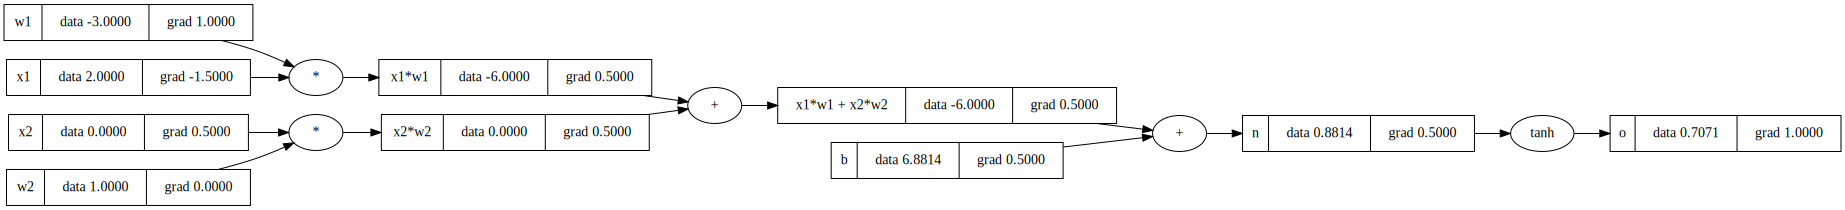

In [37]:
draw(o)

Let's incorporate this feature into our new `Value` class:

In [38]:
class Value(Value):
    def backward(self):
        topo = []
        visited = set()
        def toposort(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    toposort(child)
                topo.append(v)
        toposort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

To verify it works, we re-make our neuron's output:

In [39]:
make_neuron_output()

and...

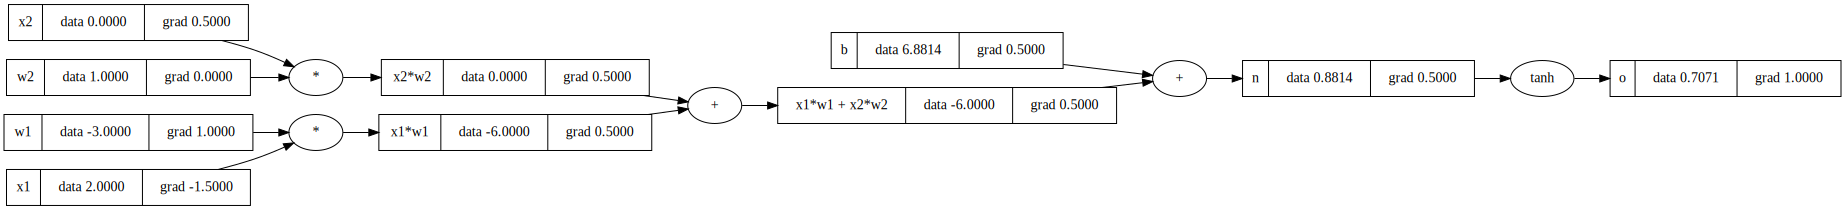

In [40]:
o.backward()
draw(o)

Voilà! **backprop** with a single backward call. Let's test it out one more time:

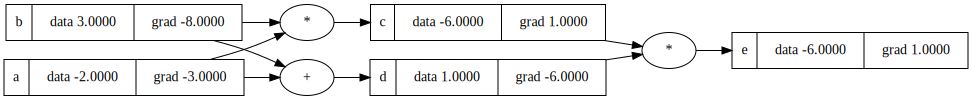

In [41]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = d * c; e.label = 'e'
e.backward()
draw(e)

Nice. That was easy... right? Next up, just to prove that this process works more generally, let's exercise by adding a few more complex operations to our `Value` class.

First, a power operation:

In [42]:
class Value(Value):
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = self.__class__(
            data=self.data**other,
            prev=(self,),
            op=f'**{other}',
        )
        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

In [43]:
a = Value(2.0)
b = 3.0
c = a**b
c.grad = 1.0; c._backward()
assert a.grad == b * a.data**(b - 1)

Also, a division operation:

In [44]:
class Value(Value):
    def __truediv__(self, other):  # self / other
        return self * other**-1

In [45]:
a = Value(2.0)
b = Value(4.0)
c = a / b
assert c.data == (a * (1/b.data)).data == (a * b**-1).data
c.grad = 1.0; c._backward()
assert a.grad == 1 / b.data

And last, but not least, an exponentiation operation:

In [46]:
class Value(Value):
    def exp(self):
        out = self.__class__(
            data=math.exp(self.data),
            prev=(self,),
            op='exp',
        )
        def _backward():
            # import ipdb;ipdb.set_trace()
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

In [47]:
a = Value(2.0)
a_exp = a.exp()
a_exp.grad = 1.0; a_exp._backward()
assert a.grad == a_exp.data

Using these newly defined operations, we can now express the [`tanh` operation](https://en.wikipedia.org/wiki/Hyperbolic_functions#Exponential_definitions) as a composite operation, consisting of a combination of those, as follows:

In [48]:
class Value(Value):
    def tanh(self):
        e = (2*self).exp()
        return (e - 1) / (e + 1)

In [49]:
a = Value(2.0)
a_tanh = a.tanh()
a_tanh.backward()
assert math.isclose(a.grad, (1 - a_tanh.data**2))

Furthermore, re-making the neuron output, now  with the new, composite `tanh`, and doing **backprop**

In [50]:
make_neuron_output()
o.backward()

should yield us...

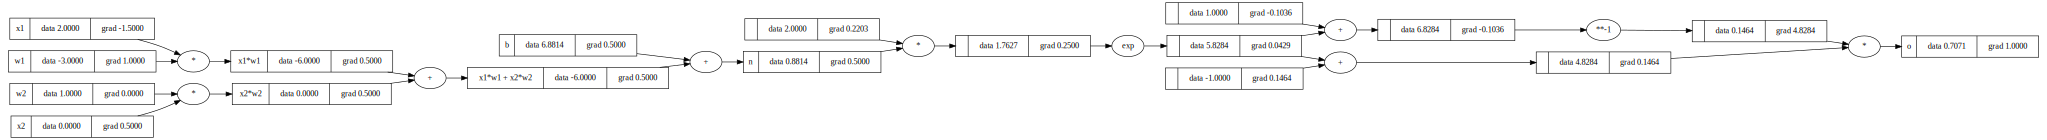

In [51]:
draw(o)

...the same gradients as before! In the end, what matters is being able to do a functional forward pass and backward pass (**backprop**) on the output of any of such operation we have defined, no matter how "composite" it is. If you apply the chain rule properly, as demonstrated, the design of the function and it's complexity are totally up to you. As long as the backward processes are correct, properly, all is good.

So now let's do the exact same thing using a modern deep neural network library, like [pytorch](https://pytorch.org/), on which **micrograd** is roughly modeled.

In [52]:
import torch

In pytorch, the equivalent of our `Value` object is the `Tensor` object. Tensors are just n-dimensional arrays of scalars. Examples:

In [53]:
torch.Tensor([2.])  # 1x1 tensor
torch.Tensor([[1., 2., 3.], [4., 5., 6.]])  # 2x3 tensor

tensor([[1., 2., 3.],
        [4., 5., 6.]])

Like **micrograd**, pytorch let's us construct the mathematical expression of a neuron function on which we can perform **backprop**!

In [54]:
x1 = torch.tensor([2.0]).double().requires_grad_(True)
x2 = torch.tensor([0.0]).double().requires_grad_(True)
w1 = torch.tensor([-3.0]).double().requires_grad_(True)
w2 = torch.tensor([1.0]).double().requires_grad_(True)
b = torch.tensor([6.8813735870195432]).double().requires_grad_(True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


`tensor()` makes a tensor, `double()` casts it to a double-precision data type (as does python by default) and `requires_grad_()` set enables gradient calculation for that tensor. In pytorch, one has to explicitly enable it gradient calculation is disabled by default for efficiency reasons. Above, we just use single-element scalar tensors. But the whole point of pytorch is to work with multi-dimensional tensors that can be acted upon in parallel by many different operations. Nevertheless, what we have built very much agrees with the API of pytorch!

Let's now construct the mathematical expression that constitutes a **nn** piece by piece, specifically, a 2-layer **mlp**. We'll start out by writing up a neuron as we've implemented it so far, but making it subscribe to the pytorch API model in how it designs its **nn** modules.

In [55]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

`w` is an array of values that represents the weights of the `nin` input neurons and `b` the bias of this neuron. Now, we are gonna implement the forward pass call: the sum of the products of each `w` and input `x` and bias (`w * x + b`) passed through a non-linear activation function (e.g. `tanh`).

In [56]:
class Neuron(Neuron):
    # w * x + b
    def __call__(self, x):
        act = sum((w * x for w, x in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

Here's an example of passing two inputs `x` through the neuron:

In [57]:
x = [2.0, 3.0]
nin = len(x)
n = Neuron(nin)
n(x)

Value(data='-0.36134581365735324')

Having done so, let's create a `Layer` object that represents a layer composed of many neurons as in typical **nn** fashion. It takes the number of input and output neurons (`nin`, `nout`) as arguments.

In [58]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

Here's an example of passing two inputs `x` through a layer of neurons:

In [59]:
x = [2.0, 3.0]
nin = len(x)
nout = 3
l = Layer(nin, nout)
l(x)

[Value(data='0.97641791246526'),
 Value(data='0.987971921943508'),
 Value(data='-0.9970753874155555')]

As expected, after passing in `nin` input values, we get `nout` output values.

Finally, we'll implement an **mlp**, in which layers basically feed into each other sequentially. First, we define a constructor that creates a list of layers, each one initialized with the proper number of inputs and outputs, given an initial `nin` and `nouts` list. Then, a forward pass method that passes an initial input `x` through each of the layers, from first to last.

In [60]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

Here's an example reconstructing the [mlp example](#MLP-example) we saw previously. It has 3 input neurons, two hidden 4-neuron layers and a 1-neuron output layer, therefore:

In [61]:
def define_mlp():
    return MLP(3, [4, 4, 1])
mlp = define_mlp()
x = [2.0, 3.0, -1.0]
mlp_out = mlp(x)
mlp_out

Value(data='-0.6103024074595436')

And if we draw our single **mlp** output...

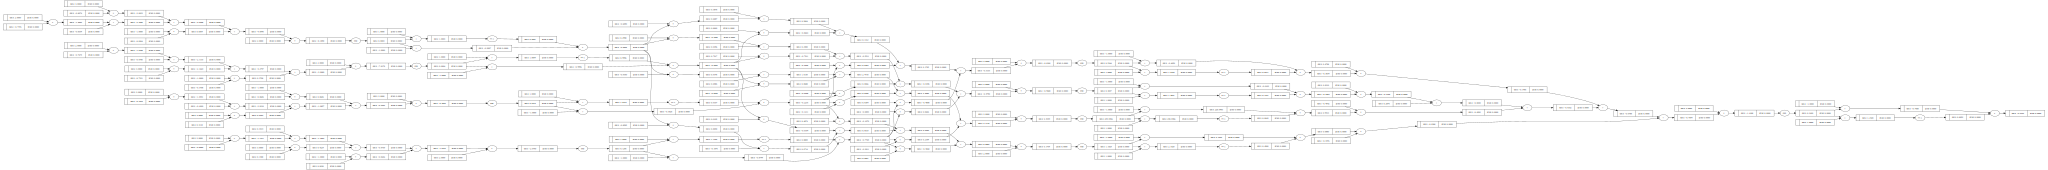

In [62]:
draw(mlp_out)

Wow! That's a big graph! Now obviously, no one sane enough would dare differentiate these expressions with pen and paper. But with **micrograd** you'll be able to **backprop** all the way through this back into the leaf nodes, meaning the weights of our neurons (`Neuron.w`).

To test it out, let's define our own inputs dataset (`xs`) to be fed into our **mlp**, as well as their corresponding target values `ys`. Basically, a simple binary classifier **nn**, since input corresponds to either `1.0` or `-1.0`.

In [63]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

Each one of the input vectors corresponds to each target value of `y`. E.g. `[2.0, 3.0, -1.0]` corresponds to target `1.0`, `[3.0, -1.0, 0.5]` to `-1.0`, and so on. Now, `ys` are the *desired* values. Now, let's pass `xs` through our **mlp** and get the predicted values `ypred`:

In [64]:
def forward_pass_mlp(mlp):
    return [mlp(x) for x in xs]
ypreds = forward_pass_mlp(mlp)
ypreds

[Value(data='-0.6103024074595436'),
 Value(data='-0.4510102976663738'),
 Value(data='-0.43179150742418226'),
 Value(data='-0.5820769821151441')]

As you can see, currently, our **mlp** outputs values (`ypreds`) that are different from the desired target values we want (`ys`). So, how do we make `ypreds` equal, or at least as close as possible, to `ys`? Specifically, how do we tune the weights (aka, train our **nn** **w.r.t.** them) in order to better predict the desired targets? The trick used in deep learning that helps us achieve this, is to calculate a single number that somehow measures how well the **nn** is performing. This number is called the **loss**. Right now, `ypred` is not close to `ys`, so we are not perfoming very well, meaning that the **loss** value is high. Our goal is to minimize the **loss** value and, by doing so, bring each `ypred` closer to its corresponding `y`. One way to calculate the **loss** value is through the mean squared error (**MSE**) function. This function will iterate over pairs of `ys` and `ypreds` and sum the squares of their differences.

The squared difference of two values (e.g. a prediction and target value) discards any negative signs and gives us a positive quantification that represents how they those values differ, aka their **loss**. If the **loss** is zero, the two values do not differ and are equal. Whereas if the **loss** is another, non-zero number, the two values are different and unequal. In general, the more two values differ, the greater their **loss** will be. The less they differ, the lower their **loss** will be. The final **MSE** **loss** of all such pairs will just be the sum of all the squared differences:

In [65]:
def calc_loss(ypreds, ys):
    return sum([(ypred - y)**2 for ypred, y in zip(ypreds, ys)])
loss = calc_loss(ypreds, ys)

Now we want to minimize the **loss**, because if teh **loss** is low, then every one of the predictions is equal to its target. The lowest the **loss** value can be is `0` (the ideal value), whereas the greater it is, the worse off the **nn** is predicting. How do we minimize the **loss**? First, **backprop**!

In [66]:
loss.backward()

After doing a backward call, something magical happened! All gradients of the **loss** **w.r.t.** weights of our **mlp** were calculated. To see this with our eyes, let's print out the `grad` attribute of any of the weights, e.g.:

In [67]:
mlp.layers[0].neurons[0].w[0].grad

-0.05104443751598642

We see that because the gradient of this particular weight of this particular neuron of this particular layer of our **nn** is negative, we see that its influence on the **loss** is also negative. Which means, that slightly increasing this particular weight, would make the **loss** value go down. Now if we draw the **loss**...

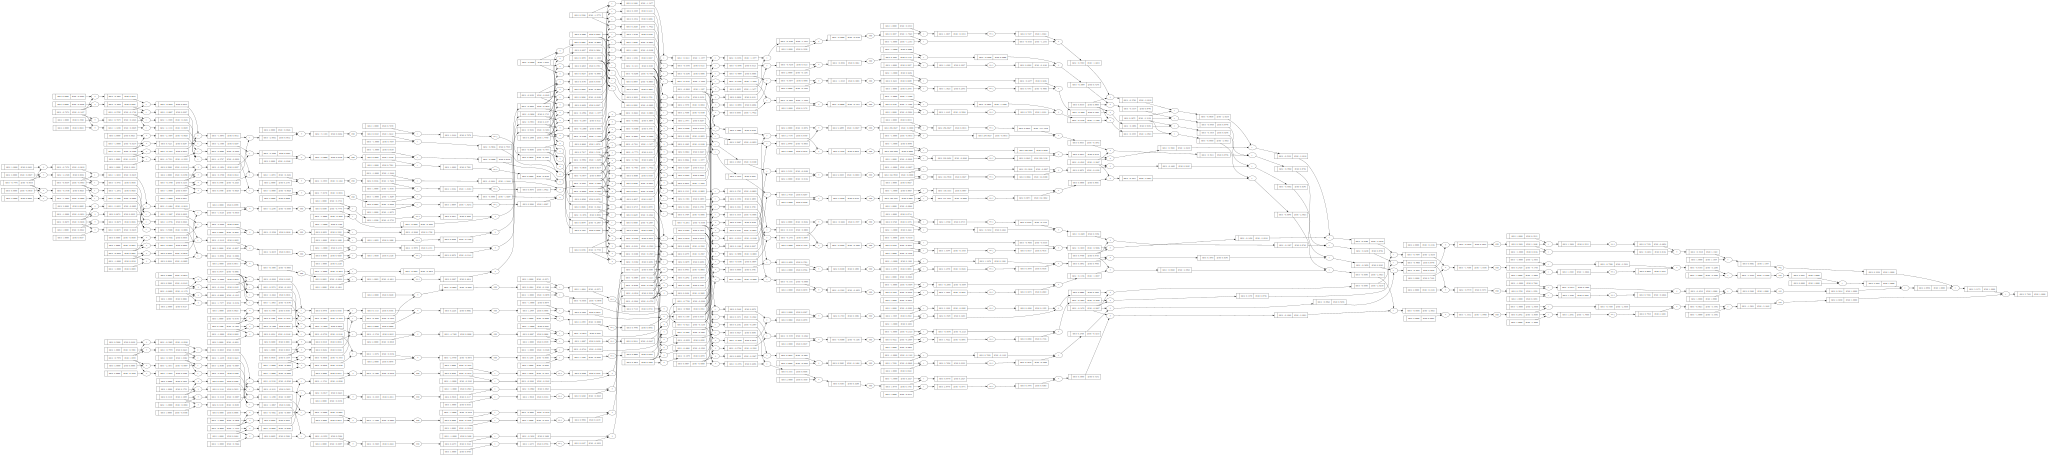

In [68]:
draw(loss)

we see that it's MASSIVE! The reason is that the loss depends on all the values produced by the forward passing all the `x` values contained in `xs` into the **mlp**. Now, although the gradients of all the values in the graph have been calculated, we only care about the gradients of the parameters we want to change, namely the weights and biases. So, our next steps are to gather those parameters and tune them by nudging them based on their gradient information. To do so, we first extend the **mlp** component classes by implementing parameters getter methods:

In [69]:
class Neuron(Neuron):  
    def parameters(self):
        return self.w + [self.b]
class Layer(Layer):  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
class MLP(MLP):
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

After getting our output and loss again (due to redefining the classes)...

In [70]:
mlp = define_mlp()
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
loss.backward()

we may inspect all the parameters...

In [71]:
mlp_params = mlp.parameters()
print(mlp_params)
print(len(mlp_params))

[Value(data='0.6860275884107312'), Value(data='0.8189996345432282'), Value(data='0.042412430676657564'), Value(data='0.9733318005194622'), Value(data='0.714060508254361'), Value(data='0.974309199665369'), Value(data='-0.017913395411821575'), Value(data='0.7076243214762752'), Value(data='0.6923331357902311'), Value(data='-0.21775639744398556'), Value(data='-0.9289471759942083'), Value(data='0.7515303188977451'), Value(data='-0.46473152573430676'), Value(data='-0.12396458926106946'), Value(data='0.42053250336425574'), Value(data='0.46354594458465703'), Value(data='0.11530688213034801'), Value(data='0.7509415300194728'), Value(data='0.7604300624602411'), Value(data='0.910199477411967'), Value(data='0.5542868493960045'), Value(data='0.5286066851692754'), Value(data='0.4766247328780564'), Value(data='0.5120518788074204'), Value(data='0.0670206877696291'), Value(data='0.4620392116505183'), Value(data='0.3181165961807626'), Value(data='0.7767173486236847'), Value(data='0.9620512894836923'), V

and change them in a manner that decreases the loss. Before we optimize all of them though, let's first optimize only one to see exactly how the process is done:

In [72]:
mlp.layers[0].neurons[0].w[0].grad

0.002776093676704034

In [73]:
mlp.layers[0].neurons[0].w[0].data

0.6860275884107312

To understand how to optimize the parameters, let's understand th relationship between `grad` and **loss** through the two distinct cases.

**A**. A positive parameter `grad` (`>0`) value tells us that:
- (**1**) *increasing* that parameter would *increase* the **loss**
- (**2**) *decreasing* that parameter would *decrease* the **loss**

**B**. A negative parameter `grad` (`<0`) value tells us that:
- (**1**) *increasing* that parameter would *decrease* the **loss**
- (**2**) *decreasing* that parameter would *increase* the **loss**

Since, we only care about *decreasing* the **loss** (since we want to minimize it), we only care about cases **A2** and **B1**. Therefore, we now know that *decreasing* the **loss** depends on changing the weight by an amount whose sign is the opposite of the `grad` value. Since the opposite of a value is just it's negation, we describe the general optimization step required to change each parameter as follows:

> To decrease the **loss**, change each parameter `p` in the direction that is opposite the direction of the the gradient `grad` of the **loss**.

This can be achieved by subtracting the product of the gradient and a small step size `α` from the current parameter value:
`p = p - α * grad`, where `α` is a usually small positive number (e.g. `0.001`) called the learning rate, which determines how big of a step size is taken during each optimization step. Since we descend the gradient, we call this process gradient descent. Let's now optimize one weight parameter with one step of gradient descent:

In [74]:
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
# zero gradients (so they don't accummulate)
for p in mlp.parameters():
    p.grad = 0.0
loss.backward()
mlp.layers[0].neurons[0].w[0].data += -0.001 * mlp.layers[0].neurons[0].w[0].grad
ypreds_after = forward_pass_mlp(mlp)
loss_after = calc_loss(ypreds_after, ys)
print(f'Loss before optimization step: {loss}')
print(f'Loss after optimization step: {loss_after}')

Loss before optimization step: Value(data='7.4896801957318075')
Loss after optimization step: Value(data='7.489680188025078')


See? Loss after the step is lower than before it. So, optimizing even one parameter with this procedure, decreases the **loss** of our **mlp**! But in order to decrease it even more, let alone minimize it, we must also optimize all of the parameters. How? Like this:

In [75]:
ypreds = forward_pass_mlp(mlp)
loss = calc_loss(ypreds, ys)
# zero gradients (so they don't accummulate)
for p in mlp.parameters():
    p.grad = 0.0
loss.backward()
for p in mlp.parameters():
    p.data += -0.001 * p.grad
ypreds_after = [mlp(x) for x in xs]
loss_after = sum([(ypred - y)**2 for ypred, y in zip(ypreds_after, ys)])
print(f'Loss before optimization step: {loss}')
print(f'Loss after optimization step: {loss_after}')
print([y.data for y in ypreds])
print([y.data for y in ypreds_after])
print(ys)

Loss before optimization step: Value(data='7.489680188025078')
Loss after optimization step: Value(data='7.486082535349771')
[0.9473691572690347, 0.9498597253967446, 0.9189863752652301, 0.9505174248785327]
[0.9470049733774584, 0.9495090235535515, 0.9183862378749681, 0.9501715751979674]
[1.0, -1.0, -1.0, 1.0]


Same thing happens: **loss** decreases! Most importantly, each time we re-run the optimization, the prediction values get even closer to the target values, which is our primary goal! In general, we must be careful with our step size. Too small of a step size will take many many steps to decrease the **loss**, whereas too big of a step size might be an *overstep* that causes an increase instead of a decrease of the **loss**. Sometimes, if the increase is too big, the **loss** value explodes. Finding a step size that is just right can be a subtle art sometimes. You can play around with the step size, re-running the cells each time, to see its effect. All in all, we have being able to derive a set of parameters (weights and biases):

In [76]:
mlp.parameters()

[Value(data='0.6860220361988462'),
 Value(data='0.818996978019214'),
 Value(data='0.042409138420331484'),
 Value(data='0.9733283145345162'),
 Value(data='0.7140311226276517'),
 Value(data='0.9742995671931061'),
 Value(data='-0.017933688828783646'),
 Value(data='0.7076006317301089'),
 Value(data='0.6921994890335752'),
 Value(data='-0.21801364515412497'),
 Value(data='-0.9292070453274567'),
 Value(data='0.7512700204845435'),
 Value(data='-0.4648028864948369'),
 Value(data='-0.12394831673027168'),
 Value(data='0.42051173381307294'),
 Value(data='0.4635156809656749'),
 Value(data='0.1152267652827232'),
 Value(data='0.7508627652960566'),
 Value(data='0.7603966020137668'),
 Value(data='0.9101959892327535'),
 Value(data='0.5542047001492366'),
 Value(data='0.5286502027093877'),
 Value(data='0.47666769323535413'),
 Value(data='0.5120591983402032'),
 Value(data='0.06703302814470126'),
 Value(data='0.46208384401588326'),
 Value(data='0.317843565249372'),
 Value(data='0.7764474495249776'),
 Value(

that makes our network predict the target values. Basically, we have learned how to train a **nn**! But, let's make it a bit more respectable by implementing a training loop.

In [77]:
for k in range(20):
    # forward pass
    ypreds = forward_pass_mlp(mlp)
    loss = calc_loss(ypreds, ys)
    # zero gradients (so they don't accummulate)
    for p in mlp.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()
    # update
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 7.486082535349771
1 7.273687770861671
2 6.872379261662175
3 6.034461960048788
4 4.45383763483645
5 3.4340606193513494
6 3.256501175843156
7 3.1161897113902857
8 3.010549613374173
9 2.9322743885232248
10 2.8733497588251367
11 2.8271332523161496
12 2.788586635519551
13 2.753764276128195
14 2.7190922072861223
15 2.6804601521108666
16 2.6317771493886366
17 2.5621083005706335
18 2.449585878592506
19 2.251119074668328


After training, prediction values should be significantly closer to target values:

In [78]:
print([y.data for y in ypreds])
print(ys)

[0.33702660098204446, 0.12026279008148054, -0.7835682410831867, 0.28602946716693006]
[1.0, -1.0, -1.0, 1.0]


Let's now bring together and summarize what we have learned. **nn**s are functions that take the data as well as the weights and biases (parameters) as inputs to produce outputs. The outputs, or `predictions`, together with target values are then passed through a **loss** function that yields a **loss** value that represents their distance in terms of close or far apart they are. We train **nn**s by using **backprop** to calculate the gradient of the **loss** **w.r.t.** the parameters. These gradients are used to then optimize those parameters using gradient descent in order to minimize the **loss**. The end goal is for the **nn** to perform a given task. Although relatively simple expressions, it turns out that **nn**s can solve very complicated problems. Sometimes, if the problem is complex enough, and the **nn** big enough (100 billion+ parameters), fascinating proprties arise, as in the case of [GPT](https://en.wikipedia.org/wiki/Generative_pre-trained_transformer), for example. This model, trained with amounts of texts from the internet can predict, given some words, the next words in a sequence.

This brings us to the end of the [micrograd tutorial](#1.-micrograd). I hope you enjoyed this tutorial and found it helpful! For more (tests, demo, etc.), see the [original micrograd repository](https://github.com/karpathy/micrograd).

Now it's time to *make more*.

### 2. **makemore** (part 1): implementing a bigram character-level language model

Just like [micrograd](#1.-micrograd) before it: *step-by-step* with everything *spelled-out*, we are going build **makemore**: a bigram character-level language model. We're going to build it out slowly and together! But what is **makemore**? As the name suggests, **makemore** makes more of things that you give it. Here's an example: [names.txt](names.txt) is an example of dataset to *make more*. Specifically, it is a very large list of different names. If you train **makemore** on this dataset, it will learn to *make more* of name-like things, basically more unique names! So, maybe if you have a baby and you're looking for a new, cool-sounding unique name. Here are some examples of such names that the **makemore** will be able to generate:

```text
dontell
khylum
camatena
aeriline
najlah
sherrith
ryel
irmi
taislee
mortaz
akarli
maxfelynn
biolett
zendy
laisa
halliliana
goralynn
brodynn
romima
chiyomin
loghlyn
melichae
mahmed
irot
helicha
besdy
ebokun
lucianno
```

`dontell`, `irot`, `zendy`, and so on, you name it! So under the hood, **makemore** is a character-level language model. That means that it's treating every single line (i.e. name) of [its training dataset](names.txt) as an example. And each example is treated as a sequence of individual characters. For instance, it treats the name `reese` as the sequence of characters: `r`, `e`, `e`, `s`, `e`. That is the level on which we are building out **makemore**. Basically, its purpose is: given a character, it can predict the next character in the sequence based upon the names that it has seen so far. Now, we're actually going to implement a large number of character-level language models, following a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

In fact, the transformer we are going to build will be the equivalent of [GPT-2](https://en.wikipedia.org/wiki/GPT-2). Kind of a big deal, since it's a modern network and by the end of this guide you'll actually understand how it works at the level of characters. Later on, we will probably spend some time on the word level, so we can generate documents of words, not just segments of characters. And then we're probably going to go into image and image-text networks such as [DALL-E](https://en.wikipedia.org/wiki/DALL-E), [Stable Diffusion](), and so on. But first, let's jump into character-level modeling, starting by reading all the names into a list:

In [79]:
words = open('names.txt').read().splitlines()

In [80]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Now, we want to learn a bit more about this dataset.

In [81]:
len(words)

32033

In [82]:
len(min(words, key=len))  # shortest 

2

In [83]:
len(max(words, key=len))

15

So now, let's think through our very first language model. A character-level language model is predicting the next character in the sequence given already some concrete sequence of characters before it. What we have to realize here, is that every single word like `isabella` is actually quite a few examples packed in that single word. Because, let's think: what is a word telling us really? It's saying that the character `i` is a very likely character to come first in the sequence that constitutes a name. The character `s` is likely to come after `i`, the character `a` is likely to come after `is`, the character `b` is likely to come after `isa`, and so on all the way to `a` following `isabell`. And then there's one more example packed, one more important piece of information in here. And that is after `isabella`, the word is very likely to end.

Time to build our first network: a bigram language model. In these, we are working with two characters at a time. So, we are only looking for one character we are given and we are trying to predict the next character in a sequence. For example, in the name `charlotte`, we ask: what characters are likely to follow `r`?  In the name `sophia`: we ask what characters are likely to follow `p`? And so on. This mean we are just modeling that local structure. Meaning, we only look at the previous character, even though there might be a lot of useful information before it. This is a very simple model, which is why it's a great place to start!

We can learn about the statistics of which characters are likely to follow which other characters by counting. So by iterating over all names, we can count how often each consecutive pair (bigram) of characters appears.

In [84]:
b = {}
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

Notice that we have also added `.` to signify the start and end of each word of each word. Obviously now, `b` now holds the statistics of the entire dataset.

In [85]:
sorted(b.items(), key=lambda tup: tup[1], reverse=True)

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

And this is the sorted list of counts of the individual bigrams across all the words in the dataset! Now let's convert our current bigram-to-occurence-frequency map into a bigram counts array, where every row index represents the first character and every column index represents the second character of each bigram. Before doing so, we must first find a way to convert each character into a unique integer index:

In [86]:
chars = ['.'] + sorted(list(set(''.join(words))))
ctoi = {c: i for i, c in enumerate(chars)}
print(ctoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


Now that we have a character-to-index map, we may construct our bigram counts array `N`:

In [87]:
import torch
nchars = len(chars)
N = torch.zeros(nchars, nchars, dtype=torch.int32)
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[ctoi[ch1], ctoi[ch2]] += 1

In [88]:
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

Done! Of course, this looks like a mess. So let's visualize it better.

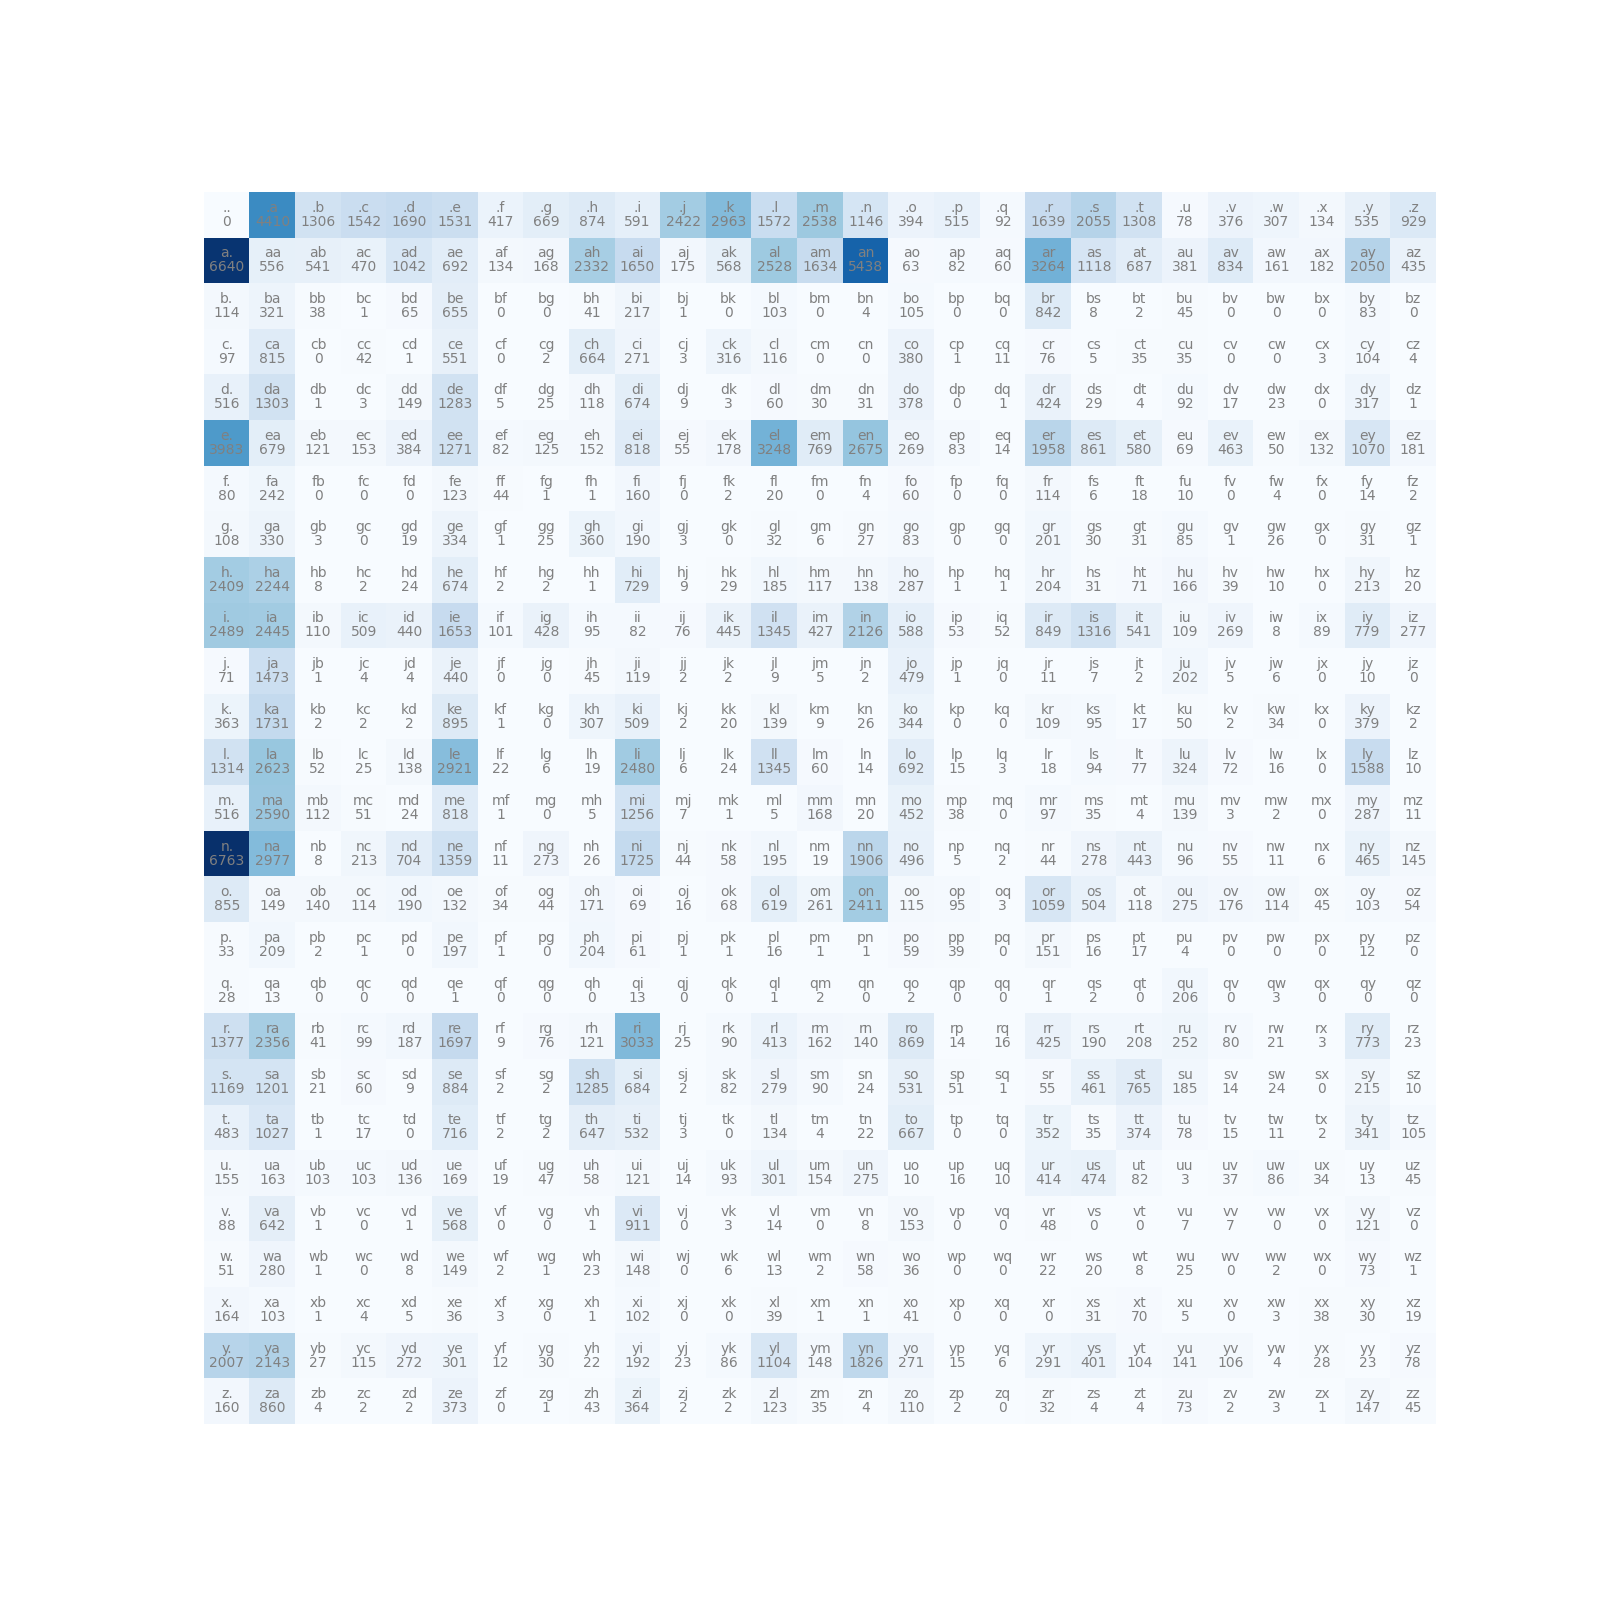

In [89]:
itoc = {i: c for c, i in ctoi.items()}
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16));
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

The color-graded bigram counts array! Looks good. This array actually has all the necessary information for us to start sampling from this bigram character language model. Let's just start by sampling the start character (of course) of each name: the `.` character. The first row tells us how often each other character follows it. In other words, the first row tells us how often each character is the first character of a word:

In [90]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

To get the probability of each of character being the first:

In [91]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Each value of this probability distribution corresponds simply to the probability of the corresponding character being the first character of a word. And of course it sums to `1`:

In [92]:
assert p.sum() == 1

Now, we'll sample numbers according to this probability distribution using [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html#torch-multinomial). And to do so deterministically we are going to use a generator. So, let's take a brief detour and test out how to sample. First we create a probability distribution:

In [93]:
SEED = 2147483647
g = torch.Generator().manual_seed(SEED)
ptest = torch.rand(3, generator=g)
ptest = ptest / ptest.sum()
ptest

tensor([0.6064, 0.3033, 0.0903])

Then, we sample from this distribution:

In [94]:
s = torch.multinomial(ptest, num_samples=100, replacement=True, generator=g)
s

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

Simple. Now, notice that it outputs the same tensor however many times you run the cells. That's because we have set a fixed seed and passed the generator object to the functions. Now, notice the output of `torch.multinomial`. What we expect is that around `60.64%` of the numbers to be `0`, `30.33%` to be `1` and `9.03%` to be `2`:

In [95]:
sbc = torch.bincount(s)
for i in [0, 1, 2]:
    print(f'Ratio of {i}: {sbc[i]/sbc.sum()}')

Ratio of 0: 0.6100000143051147
Ratio of 1: 0.33000001311302185
Ratio of 2: 0.05999999865889549


Not too far away from what we expected! But, if we increase the number of samples, we will get much closer to the probabilities of our distribution. Try it out! The more samples we take, the more the actual occurence ratios match the probabilities of the distribution the numbers were sampled from. Now, it's time to sample from our initial character probability distribution:

In [96]:
g = torch.Generator().manual_seed(SEED)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itoc[idx]

'j'

We are now ready to write out our name generator.

In [97]:
g = torch.Generator().manual_seed(SEED)
P = N.float()
P = P / P.sum(1, keepdim=True)  # sum over the column dimension and keep column dimension
for i in range(20):
    out = []
    idx = 0
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[idx])
        if idx == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


It works! It yields names. Well, kinda. Some look name-like enough but most are just terrible. Lol. This is a  bigrams for you! To recap: we trained a bigrams language model essentially just by counting how frequently any pairing of characters occurs and then normalizing so that we get a nice probability distribution. Really, the elements of array `P` are the parameters of our model that summarize the statistics of these bigrams. We train the model and iteratively sample the next character and feed it in each time and get the next character. But how do we evaluate our model? We can do so, by looking at the probability of each bigram.

In [98]:
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        print(f'{ch1}{ch2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


Here we are looking at the probabilities that the model assigns to every bigram in the dataset. Just keep in mind that we have 27 characters, so if everything was equally likely we would expect all probabilities to be:

In [99]:
1/27.

0.037037037037037035

Since they are not and we have mostly higher probabilities, it means that our model has learned something useful. In an ideal case, we would expect the bigram probabilities to be near `1.0` (perfect prediction probability). Now, when you look at the literature of [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), statistical modelling and so on, you'll see that what's typically used here is something called the likelihood: the product of all the above probabilities. This gives us the probability of the entire dataset assigned by the model that you made. But, because the product of these probabilities is an unwieldly, very tiny number to work with (think `0.0478 * 0.0377 * 0.0253 * ...`), so, for convenience, what people usually work with is not the likelihood, but the log-likelihood. The log, as you can see:

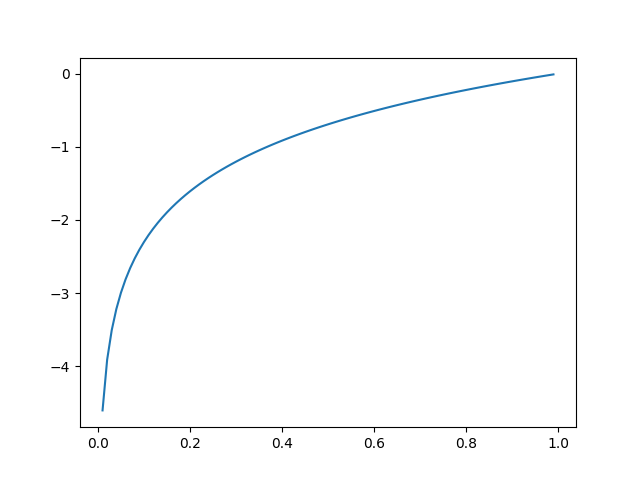

In [100]:
plt.figure()
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x)
plt.plot(x, y)

is a monotonic transformation of the probability, where if you pass in probability `1.0` you get log-probability of `0`, and as the probabilities you pass in decrease, the log-probability decreases, all the way to $-\infty$ as we approach `0`. Therefore, let's also add the log probability in our loop to see what that looks like:

In [101]:
def test_model(iterable, print_probs=True, calc_ll=False, print_nll=False):
    if print_nll:
        calc_ll = True
    log_likelihood = 0.0
    n = 0
    for w in iterable:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2 in zip(chs, chs[1:]):
            prob = P[ctoi[ch1], ctoi[ch2]]
            logprob = torch.log(prob)
            if calc_ll:
                log_likelihood += logprob
                n += 1
            if print_probs:
                print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
    if calc_ll:
        print(f'{log_likelihood=}')
    if print_nll:
        nll = -log_likelihood
        print(f'{nll=}')
        print(f'loss={nll/n}')
    return log_likelihood
_ = test_model(words[:3])

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299


As you can see, for higher probabilities we get closer and closer to `0`, but lower probabilities gives us a more negative number. And so to calculate the log-likelihood, we just sum up all the log probabilities:

In [102]:
log_likelihood = test_model(words[:3], calc_ll=True)

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856)


Now, how high can log-likelihood get? As high as `0`! So, when all the probabilities are `1.0` it will be `0`. But the further away from `1.0` they are, the more negative the log-likehood will get. Now, we don't actually like this because we are looking for a loss function, that has the semantics where high is bad and low is good, since we are trying to minimize it. So, any ideas? We actually just need to invert the log-likelihood, aka the negative log-likelihood:

In [103]:
nll = -log_likelihood

In [104]:
print(f'{nll=}')

nll=tensor(38.7856)


NLL is a very nice loss function because the lowest is can get is zero and the higher it is, the worse off the predictions are that you are making. People also usually like to see the average of the NLL instead of just the sum:

In [105]:
test_model(words[:3], print_probs=False, calc_ll=True, print_nll=True)

log_likelihood=tensor(-38.7856)
nll=tensor(38.7856)
loss=2.424102306365967


tensor(-38.7856)

Our loss function for the training set assigned by the model yields `2.42`. The lower it is, the better off we are. The higher it is, the worse off we are. So, the job of training is produce a high-quality model, by finding the parameters that minimize the loss. In this case, ones that minimize the negative loss-likelihood loss. To summarize, our **goal** is to maximize likelihood of the data w.r.t. model parameters (in our statistical modeling case these are the bigram probabilities), which is:
- equivalent to maximizing the log likelihood (because log is monotonic)
- equivalent to minimizing the negative log likelihood
- equivalent to minimizing the average negative log likelihood

The lower the nll loss the better, since that would mean assigning high probabilities
Remember: $\log(a \times b \times c) = \log(a) + \log(b) + \log(c)$. Also, keep in mind that here we store the probabilities in a table format. But in what's coming up, these numbers will not be kept explicitly but they will be calculated by a **nn** and we will change its parameters to maximize the likelihood of these probabilities.

Let's test out our model with a random name:

In [106]:
test_model(iterable=['christosqj'], calc_ll=True, print_nll=True)

.c: 0.0481 -3.0337
ch: 0.1880 -1.6713
hr: 0.0268 -3.6199
ri: 0.2388 -1.4320
is: 0.0743 -2.5990
st: 0.0944 -2.3605
to: 0.1197 -2.1224
os: 0.0635 -2.7563
sq: 0.0001 -9.0004
qj: 0.0000 -inf
j.: 0.0245 -3.7098
log_likelihood=tensor(-inf)
nll=tensor(inf)
loss=inf


tensor(-inf)

As you can see, the probability of bigram `'sq'` is super low. Whereas the probability for `'qj'`, since it is never encountered in our training data (see our bigram count table!), is `0`, which predictably yields a log-probability of $-\infty$, which in turn causes the loss to be $-\infty$. What this means is that this model is exactly $0 \%$ likely to predict this name (infinite loss). If you look up the table you see that `q` is followed by `j` zero times. This kind of behavior people don't usually likely, so there is a simple trick to alleviate it: model smoothing. It involves adding some fake counts to the bigram counts array so that never is there a bigram with `0` counts (and therefore `0` probability). This ensures that there are no zeros in our bigram counts matrix. E.g.

In [107]:
P = (N+1).float()
P = P / P.sum(1, keepdim=True)  # sum over the column dimension and keep column dimension
test_model(iterable=['christosqj'], calc_ll=True, print_nll=True)

.c: 0.0481 -3.0339
ch: 0.1869 -1.6774
hr: 0.0268 -3.6185
ri: 0.2384 -1.4338
is: 0.0743 -2.5998
st: 0.0942 -2.3625
to: 0.1193 -2.1257
os: 0.0634 -2.7578
sq: 0.0002 -8.3105
qj: 0.0033 -5.7004
j.: 0.0246 -3.7051
log_likelihood=tensor(-37.3255)
nll=tensor(37.3255)
loss=3.3932268619537354


tensor(-37.3255)

Now, we avoid getting a loss of $-\infty$!

Ok! So we've now trained a respectable bigram character-level language model. We trained the model by looking at the counts of all the bigrams and normalizing the rows to get probability distributions. We saw that we can also then use those parameters of this model to perform sampling of new words (sample new names according to these distributions) and evaluate the quality of this model which is summarized by a single number: the nll. And the lower this number is the better the model is because it is giving high probs to the actual mixed characters of all the bigrams in our training set. Great! We basically, counted and then normalized those counts, which is sensible enough. However, let's now try a different approach by casting such a bigram language model into a **nn** framework to achieve the same goal. Our **nn** is still going to be a bigram character-level language model. It will receive a single character as an input that will pass through a bunch of weighted neurons and then output the probability distribution over the next character in the sequence. It's going to make guesses about what character is going to follow the input character. In addition, we'll be able to evaluate any setting of the parameters of the **nn**, since we have a loss function. Basically, we're going to take a look at the probabilities distributions our model assigns for our next character and find the loss between those and the labels (which are the character that we expect to come next in the bigram). By doing so, we can use gradient-based optimization to tune the weights of our **nn** that give us the output probabilities. Let's begin this alternative approach by first constructing our dataset. 

In [108]:
# Create training dataset of bigrams (x, y)
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)
        xs.append(ctoi[ch1])
        ys.append(ctoi[ch2])
# Convert to pytorch tensor (https://pytorch.org/docs/stable/generated/torch.tensor.html)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [109]:
xs

tensor([ 0,  5, 13, 13,  1])

In [110]:
ys

tensor([ 5, 13, 13,  1,  0])

Now, how do we pass each character into the **nn**? [One-hot encoding](https://en.wikipedia.org/wiki/One-hot)! With this encoding, each integer is encoded with bits.

In [111]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [112]:
xenc.shape

torch.Size([5, 27])

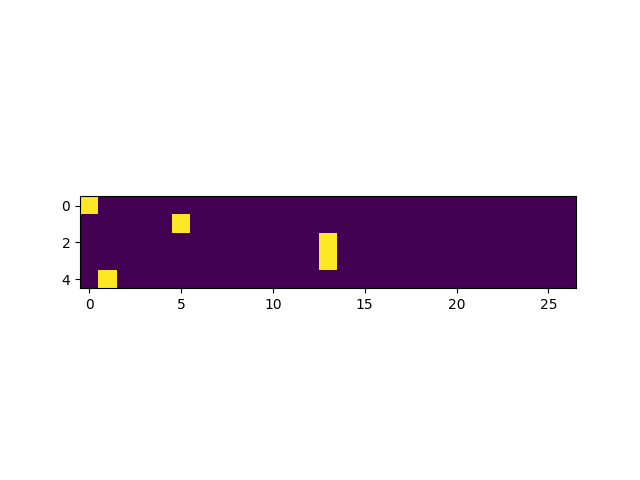

In [113]:
plt.figure()
plt.imshow(xenc)

Let's create our neuron:

In [114]:
W = torch.randn((27, 1))
xenc @ W

tensor([[-0.0256],
        [-0.6448],
        [-1.3984],
        [-1.3984],
        [-0.1029]])

Our neuron receives one character of size `27` and spits out `1` output value. However, as you can see, since pytorch supports matrix multiplication, our neuron can receive `5` characters of size `27` in parallel and output each character's output in a `(5, 1)` matrix
(`(5, 27)` @ `(27, 1)` -> `(5, 1)`). 

Now, let's pass our `5` characters as inputs through `27` neurons instead of just `1` neuron:

In [115]:
W = torch.randn((27, 27))
xenc @ W

tensor([[-1.5115e+00,  7.3961e-02,  3.6072e-01, -1.4789e+00, -2.5040e+00,
          1.8958e-01, -2.9894e-02, -1.0239e-01,  1.5294e+00,  9.5346e-01,
          8.7541e-01,  3.2433e-01, -4.0506e-01, -2.5636e-01,  7.4590e-01,
         -1.3443e+00,  5.1950e-01,  4.9983e-01, -1.1947e+00,  7.8872e-01,
         -4.5196e-01, -3.3497e-01,  6.8968e-01, -1.6296e+00, -3.7512e-01,
          3.1029e-01,  4.4183e-01],
        [-4.8968e-01, -5.6098e-01,  3.5281e-01,  2.0979e-01, -1.8045e+00,
          3.1375e-01,  1.8260e+00, -6.7437e-01, -8.1375e-01, -3.1712e-01,
          1.2569e+00,  1.8218e+00, -2.0290e+00, -9.0500e-01,  1.3292e+00,
         -3.7498e-01, -1.9506e+00, -1.0446e+00, -1.1294e+00,  1.3477e+00,
          5.0555e-01, -2.2640e-01, -9.7852e-03,  3.1429e-01,  5.2029e-01,
         -2.7822e-01, -1.3025e+00],
        [ 1.6166e+00,  6.3276e-01, -2.0932e-01, -4.6899e-01, -2.7186e-01,
         -2.7953e-01, -9.7997e-01, -2.9256e-01, -1.2233e+00,  6.8772e-01,
          1.0884e-02,  9.4882e-01,  8.13

Predictably, we get `5` arrays (one per input/character) of `27` outputs  (`(5, 27)` @ `(27, 27)` -> `(5, 27)`). Each output number represents each neuron's firing rate of a specific input. For example, the following is the firing rate of the 13th neuron of the 3rd input:

In [116]:
(xenc @ W)[3, 13]

tensor(0.1782)

What pytorch allows is matrix multiplication that enables parallel dot products of many inputs in a batch with the weights of neurons of a **nn**. For example, this is how to multiply the inputs that represent the 3rd character with the weights of the 13th neuron:

In [117]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [118]:
W[:, 13]

tensor([-0.2564,  0.5011, -1.2216,  0.8810,  0.7012, -0.9050, -0.7602,  0.1644,
        -0.1338, -1.5800, -1.7486,  0.4847,  0.2525,  0.1782,  0.3450, -0.7462,
         0.9806, -0.6597,  0.8571, -1.2407, -0.3041, -0.0748, -0.0052,  2.2715,
         2.0428, -1.6262,  1.9370])

In [119]:
(xenc[3] * W[:, 13]).sum()

tensor(0.1782)

In [120]:
(xenc @ W)[3, 13]  # same as above

tensor(0.1782)

Ok, so what did is we fed our 27-dimensional inputs into the first layer of a neural network that has 27 neurons. These neurons perform `W * x`, they don't have a bias and they don't have a non-linearity like `tanh`. We are going to leave our network as is: a 1-layer _linear_ **nn**. That's it. Basically, the dumbest, smallest, simplest neural net. Remember, what we trying to produce is a probability distribution for a next character in a sequence. And there's 27 of them. But we have to come up with exact semantics as to how we are going to interpret these 27 numbers that these neurons take on. Intuitively, as we can see in the `xenc @ W` output, some of these outputs numbers are positive and some negative. That's because they come out of a **nn** layer with weights are initialized from the normal `[-1, 1]` distribution. But, what we want however is something like a bigram count table that we previously produced, where each row told us the counts which we then normalized to get the proababilities. So, we want something similar to come out of our **nn**. But, what we have right now, are some negative and positive numbers. Now, we therefore want these numbers to represent the probabilities for the next character with their unique characteristics. For example, probabilities are positive numbers and they sum to 1. Also, they obviously have to be probabilities. They can't be counts because counts are positive integers; not a great output from a **nn**. Instead, what the **nn** is going to output and how we are going to interpret these 27 output numbers as log counts. One way to accomplish this is exponentiating each output number that negative numbers become positive ones `less` than `1` and positive one more positive ones greater than `1`.

In [121]:
(xenc @ W).exp()

tensor([[ 0.2206,  1.0768,  1.4344,  0.2279,  0.0818,  1.2087,  0.9705,  0.9027,
          4.6154,  2.5947,  2.3999,  1.3831,  0.6669,  0.7739,  2.1083,  0.2607,
          1.6812,  1.6484,  0.3028,  2.2006,  0.6364,  0.7154,  1.9931,  0.1960,
          0.6872,  1.3638,  1.5556],
        [ 0.6128,  0.5706,  1.4231,  1.2334,  0.1646,  1.3686,  6.2092,  0.5095,
          0.4432,  0.7282,  3.5145,  6.1833,  0.1315,  0.4045,  3.7779,  0.6873,
          0.1422,  0.3518,  0.3232,  3.8485,  1.6579,  0.7974,  0.9903,  1.3693,
          1.6825,  0.7571,  0.2718],
        [ 5.0357,  1.8828,  0.8111,  0.6256,  0.7620,  0.7561,  0.3753,  0.7464,
          0.2943,  1.9892,  1.0109,  2.5827,  2.2557,  1.1950,  0.1998,  1.8313,
          0.5342,  1.1551,  4.5222,  1.8243,  0.3018,  2.6414,  0.3437,  1.3249,
          0.1648,  0.3311, 13.2442],
        [ 5.0357,  1.8828,  0.8111,  0.6256,  0.7620,  0.7561,  0.3753,  0.7464,
          0.2943,  1.9892,  1.0109,  2.5827,  2.2557,  1.1950,  0.1998,  1.8313

Such exponentiation is a great way to make the **nn** predict counts. Which are positive numbers that can take on various values depending on the setting of `W`. Let's break it down more:

In [122]:
logits = xenc @ W  # log-counts
counts = logits.exp()  # equivalent to the N bigram counts array
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0065, 0.0318, 0.0423, 0.0067, 0.0024, 0.0356, 0.0286, 0.0266, 0.1361,
         0.0765, 0.0708, 0.0408, 0.0197, 0.0228, 0.0622, 0.0077, 0.0496, 0.0486,
         0.0089, 0.0649, 0.0188, 0.0211, 0.0588, 0.0058, 0.0203, 0.0402, 0.0459],
        [0.0153, 0.0142, 0.0354, 0.0307, 0.0041, 0.0341, 0.1546, 0.0127, 0.0110,
         0.0181, 0.0875, 0.1540, 0.0033, 0.0101, 0.0941, 0.0171, 0.0035, 0.0088,
         0.0080, 0.0958, 0.0413, 0.0199, 0.0247, 0.0341, 0.0419, 0.0189, 0.0068],
        [0.1033, 0.0386, 0.0166, 0.0128, 0.0156, 0.0155, 0.0077, 0.0153, 0.0060,
         0.0408, 0.0207, 0.0530, 0.0463, 0.0245, 0.0041, 0.0376, 0.0110, 0.0237,
         0.0928, 0.0374, 0.0062, 0.0542, 0.0071, 0.0272, 0.0034, 0.0068, 0.2717],
        [0.1033, 0.0386, 0.0166, 0.0128, 0.0156, 0.0155, 0.0077, 0.0153, 0.0060,
         0.0408, 0.0207, 0.0530, 0.0463, 0.0245, 0.0041, 0.0376, 0.0110, 0.0237,
         0.0928, 0.0374, 0.0062, 0.0542, 0.0071, 0.0272, 0.0034, 0.0068, 0.2717],
        [0.0146, 0.0180,

Therefore, we have a way to get the probabilities, where each row sums to 1 (since they are normalized), e.g.

In [123]:
probs[0].sum()

tensor(1.)

In [124]:
probs.shape

torch.Size([5, 27])

What we have achieved is that for every one of our 5 examples, we now have a row that came out of our **nn**. And because of the transformations here, we made sure that this output of the **nn** can be interpreted as probabilities. In other words, what we have done is that we took inputs, applied differentiable operations on them (e.g. `@`, `.exp()`) that we can backpropagate through and we are getting out probability distributions. Take the first fed input character for example:

In [125]:
xenc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

that corresponds to the `.` symbol from the name:

In [126]:
words[0]

'emma'

The way we fed this character into the neural network is that we first got its index, then we one-hot encoded it, then it went into the **nn** and out came this distribution of probabilities:

In [127]:
probs[0]

tensor([0.0065, 0.0318, 0.0423, 0.0067, 0.0024, 0.0356, 0.0286, 0.0266, 0.1361,
        0.0765, 0.0708, 0.0408, 0.0197, 0.0228, 0.0622, 0.0077, 0.0496, 0.0486,
        0.0089, 0.0649, 0.0188, 0.0211, 0.0588, 0.0058, 0.0203, 0.0402, 0.0459])

with a shape of:

In [128]:
probs[0].shape

torch.Size([27])

27 numbers. And we interpret the numbers of `probs[0]` as the probability or _how likely it is_ for each of the corresponding characters to come next. As we train the **nn** by tuning the weights `W`, we are of course going to be getting different probabilities out for every character that you input. So, the question is: can we tune `W` such that the probabilities coming out are pretty good? The way we measure "pretty good" is by the loss function. Below you can see what have done in a simple summary:

In [129]:
# SUMMARY ------------------------------>>>>
xs  # inputs

tensor([ 0,  5, 13, 13,  1])

In [130]:
ys  # targets

tensor([ 5, 13, 13,  1,  0])

Both `xs` and `ys` constitute the dataset. They are integers representing characters of a sequence (word).

In [131]:
# Use a generator for reproducability and
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g)  # 27 incoming weights for 27 neurons
# Encode the inputs into one-hot representations
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
# Pass encoded inputs through first layer to get logits
logits = xenc @ W  # predict log-counts
# Exponentiate the logits to get fake counts
counts = logits.exp()  # counts, equivalent to N
# Normalize these counts to get probabilities
probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
# NOTE: the last 2 lines here are together called a 'softmax'
probs.shape

torch.Size([5, 27])

Softmax is a very-often-used loss function in neural networks. It takes in logits, exponentiates them and divides and normalizes. It's a way of taking outputs of a linear layer that might be positive or negative and it outputs numbers that are positive and always sum to `1`: that adhere to the properties of probability distributions. It can be viewed as a normalization function if you want to think of it that way. 

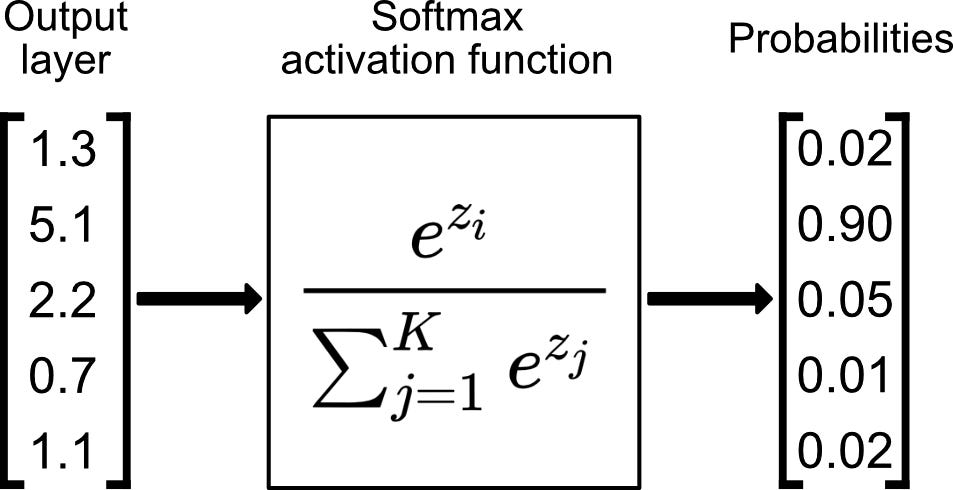

In [132]:
display(Image(filename='softmax.jpeg'))

Now, since every operation in the forward pass is differentiable and we can backpropagate through. Below, we iterate over every input character and describe what is going on:

In [133]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item() # label character index
    print('--------')
    print(f'bigram example {i+1}: {itoc[x]}{itoc[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the correct next character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll
loss = nlls.mean()
print('=========')
print('average negative log likelihood, i.e. loss =', loss.item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the correct next character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the correct next character: 

As you can see, the probabilities assigned by the net to the correct next character are bad (pretty low). See for example the probability predicted by the network of `m` following `e` (`em` example): negative log-likelihood value is very high (e.g. 4.0145). In general, for the whole word, the loss (the average nll) is high! This means that this is not a favorable setting of weights and we can do better. One easy way to do better is to reinitialize `W` using a different seed for example and pray to god that the loss is smaller or repeat until it is. But that is what amateur do. We are professionals! And what professionals do is they start with random weights, like we did, and then they optimize those weights in order to minimize the loss. We do so by some gradient-based optimization (e.g. gradient descent) which entails first doing backprop in order to compute the gradients of that weight w.r.t. to those weights and then changing the weights by some such gradient amount in order to optimize them and minimize the loss. As we did with **micrograd** we will write an optimization loop for now doing the backward pass. But instead of mean-squared error we are using the negative log-likehood as a loss function, since we are dealing with a classification task and not a regression one.

In [134]:
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)  # 27 incoming weights for 27 neurons

In [135]:
def forward_pass(regularize=False):
    num = xs.nelement()
    xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean()
    return W, loss
W, loss = forward_pass()

In [136]:
# backward pass
W.grad = None  # set to zero
loss.backward()

Now, something magical happened when `backward` was run. Like **micrograd**, pytorch, during the forward pass, keeps track of all the operation under the hood and builds a full computational graph. So, it knows all the dependencies and all the mathematical operations of everything. Therefore, calling `backward` on the loss fills in the gradients of all the intermediates, all the way back to the `W` value nodes. Take a look:

In [137]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

And obviously:

In [138]:
assert W.shape == W.grad.shape

What a gradient value is telling us, e.g.

In [139]:
W.grad[1][4]

tensor(0.0121)

is that nudging the specific corresponding weight by a small `h` value, would nudge the loss by that gradient amount. Since we want to decrease the loss we simply need to change the weights by a small negative fraction of the gradients in order to move them in the direction that locally most steeply decreases the loss value:

In [140]:
W.data += -0.1 * W.grad

We just did a single gradient descent optimization step, which means that if we re-calculate the loss, it will be lower:

In [141]:
W, loss = forward_pass()
loss

tensor(3.7492, grad_fn=<NegBackward0>)

Tada! All we have to do now is do put everything together and stick the single step into a loop so that we do multi-step gradient descent optimization. This time for all the words in our dataset, not just `emma`!

In [142]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(ctoi[ch1])
        ys.append(ctoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples (bigrams): ', num)
# initialize the 'network'
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples (bigrams):  228146


In [143]:
# gradient descent
for k in range(100):
    W, loss = forward_pass()
    print(loss.item())
    # backward pass
    W.grad = None # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad

3.758953809738159
3.371098756790161
3.1540417671203613
3.020373821258545
2.9277119636535645
2.860402822494507
2.8097293376922607
2.7701027393341064
2.7380733489990234
2.711496591567993
2.6890034675598145
2.6696884632110596
2.6529300212860107
2.638277292251587
2.6253881454467773
2.6139907836914062
2.603863477706909
2.5948219299316406
2.586712121963501
2.57940411567688
2.572789192199707
2.5667762756347656
2.5612881183624268
2.5562589168548584
2.551633596420288
2.547365665435791
2.5434155464172363
2.539748430252075
2.5363364219665527
2.5331544876098633
2.5301806926727295
2.5273969173431396
2.5247862339019775
2.522334575653076
2.520029067993164
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.510324001312256
2.5086867809295654
2.5071346759796143
2.5056610107421875
2.5042612552642822
2.502929210662842
2.5016613006591797
2.5004522800445557
2.4992990493774414
2.498197317123413
2.497144937515259
2.496137857437134
2.495173692703247
2.4942495822906494
2.493363380432129
2

Awesome! What we least expect is that our loss by using such gradient-based optimization becomes as small as the loss we got by our more primitive bigram-count-matrix way that we previously employed for optimizing. So, basically, before, we achieved roughly the same loss just by counting, whereas now we used gradient descent. It just happens that the explicit, counting approach nicely optimizes the model without the need for any gradient-based optimization because the setup for bigram language models is so straightforward and simple that we can afford to just directly estimate the probabilities and keep them in a table. However, the **nn** approach is much more flexible and scalable! So we have actually gained a lot. What we can do from hereon is expand this approach and complexify our approach. Meaning, that instead of just taking a single character and predicting the next one in an extremely simple **nn**, as we have done so far, we will be taking multiple previous characters and we will be feeding them into increasingly more complex **nn**s. But, fundamentally, we will still be just calculating logits that will be going through exactly the same transformation by passing them through a softmax and doing the same gradient-based optimization process we just did. But before we do that, remember the smoothing we did by adding fake counts to our bigram count matrix? Turns out, we can do equivalent smoothing in our **nn** too! In particular, just incentivize the weights to be zero for example leads to the probabilities being uniform which is a form of smoothing. Such incentivization can be accomplished through regularization. It involves just adding such a term:

In [144]:
(W**2).mean()

tensor(1.6880, grad_fn=<MeanBackward0>)

to the loss as such `loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()`

where `0.01` represents the strength of the regulatization term. Optimizing with this term included in the loss would smoothen the model! Yay! Lastly, let's sample from our **nn**:

In [146]:
g = torch.Generator().manual_seed(SEED)
for i in range(5):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # sample from probabilities distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cfay.
a.


We are getting kind of the same results as we previously did with our counting method! Not unpredictable at all, since our loss values are close enough. If we train our **nn** more and the loss values are the same, it means that the two models are identital. Meaning that given the same inputs, they would spit out the same outputs. So, all in all, we have actually covered lots of ground. To sum up, we introduced the bigram character language model. We saw how we can train the model, how we can sample from the model and how we can evaluate the quality of the model using the negative log-likelihood loss. We actually trained the model in two completely different ways that actually give or can give (with adequate training) the same result. In the first way, we just counted up the frequency of all the bigrams and normalized. Whereas, in the second way, we used the negative log-likelihood loss as a guide to optimizing the counts matrix or the counts array, so that the loss is minimized in a gradient-based framework. Despite our **nn** being super simple (single linear layer), it is the more flexible approach. In the follow-up lessons, we are going to complexify by taking more and more of these characters and we are going to be feeding them into a new **nn** that does more exciting stuff. Buckle up!